# Import Statements
---
**Important note:**
For some reason tensorflow version and numpy version have dependency conflicts. Need to figure out what version is stable for both of these to work together.

In [1]:

import pandas as pd                 # Pandas dataframe library
import pandas_datareader as pdr     # Pandas datareader that allows me to lookup & store live crypto prices from yahoo finance.
import numpy as np                  # Numpy
import matplotlib.pyplot as pypl    # Pyplot used to create visuals/graphics based on data 
import datetime as dt               # Datetime library.

import glob                         # For changing/finding proper directory
import os                           # For changing/finding proper directory (when opening files)

import twint                        # Twitter web scraping tool with more features than the regular twitter API
import nest_asyncio                 # Import required for twint usage.
nest_asyncio.apply()                

import re                           # Regex for string cleaning (used for Textblob Sentiment Analysis)
from textblob import TextBlob       # Textblob used for sentiment analysis of cleaned data.

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer    # Sentiment analysis tool that works great on determining social media sentiment.

from newsapi import NewsApiClient   # NewsApiClient lets me look up/pull news articles relating to specified topics.
import requests                     # Used for sending get requests to the NewsAPI client.

from sklearn.preprocessing import MinMaxScaler                          # Scaler used for scaling data (LSTMRNN Implementation)
from sklearn.metrics import accuracy_score, classification_report       
from sklearn.model_selection import train_test_split                    # Used for splitting data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    # Used for implementing SVM
import tensorflow as tf                                                 # TF used for LSTMRNN Implmentation
from keras.layers import Dense, Dropout, LSTM                           # Dense, dropout & lstm used for creating LSTMRNN 
from keras.models import Sequential                                     # Important because we're working with Sequential data.

## Reading in crypto price dataset
---
Section below reads csv files into pandas dataframes for interacting with. Also compiles list of coin names for twitter searching.

### What to do next:
* Retrieve Token labels from CSV file for searching by Cashtag on twitter.

In [5]:
path = r'c:\Users\WaKaBurd\Documents\GitHub\CryptoPredictionTool\prices\DailyPrices'
extension = 'csv'
os.chdir(path)
daily_csv_files = glob.glob('*.{}'.format(extension))


path = r'c:\Users\WaKaBurd\Documents\GitHub\CryptoPredictionTool\prices\HourlyPrices'
os.chdir(path)
hourly_csv_files = glob.glob('*.{}'.format(extension))

# Compile list of all coin names for searching on twitter later
daily_coins = []
hourly_coins = []

for coin in daily_csv_files:
    vals = coin.split("_")
    coin_name = vals[1][:-4]
    daily_coins.append(coin_name)

for coin in hourly_csv_files:
    vals = coin.split("_")
    coin_name = vals[0]
    print(coin_name)

# compile list of pandas dataframes for use later.
hourly_coin_data = []

for file in hourly_csv_files:
    df = pd.read_csv(file)
    hourly_coin_data.append(df)

AAVE
ADA
AVAX
BCH
BTC
ETH


*NOTE:* The cell below is for reading in the Bitcoin tweets dataset from Kaggle. (https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets)
This datset kinda sucks though. For a few reasons:
* Firstly, its tweets span 1.5 years but are only from 43 total days, making it inconsistent to use with Sequential data, like the price history.
* Secondly, it has some values in impropere columns (namely tag values in the date column) which have to be manually removed.
* Lastly, its huge. 280k tweets. Which at first seems great, but being that the sample size itself is incredibly sparse in terms of date-span, this leads to problems with implementation. 

I'll leave it here in a cell in case I decide to use it later, but for now, it doesn't apply to this project.

In [ ]:
#!!! BELOW IS THE LOGIC FOR READING IN THE TWEETS FROM THE BITCOIN TWEET KAGGLE DATASET !!!
# Note: This dataset kinda sucks. It has some values in the 

# Logic for reading in Bitcoin tweets dataset.
# btc_tweets = pd.read_csv('../bitcoin_tweets/Bitcoin_tweets.csv')
# btc_tweets.drop([64943], axis=0, inplace=True)
# btc_tweets.drop([137068], axis=0, inplace=True)
# btc_tweets.drop([180575], axis=0, inplace=True)

# btc_tweets.drop(btc_tweets.index[100000:len(btc_tweets)], inplace=True)
# btc_tweets.drop(columns=['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'source', 'is_retweet'], inplace=True)

## Scrape Twitter for data on all coins supplied by dataset
---
Below section of code searches through twitter using keywords. Uses sift_tweet() function to remove all unnecessary characters, links, emojis & words from tweets. Also uses Textblob to append polarity column to pandas df for tracking sentiment of tweets.

### What to do next:
* Search twitter based on Cashtags & Hashtags
* Configure Twint with Google translater so I can translate tweets from non-english langauges to english. (Need to create ticket for this in Github)

In [119]:
os.chdir(r'C:\Users\WaKaBurd\Documents\GitHub\CryptoPredictionTool\archive')
stopwords_file = open("../archive/stopwords.txt", "r+")
stopwords = list(stopwords_file.read().split('\n'))

# Need to create function for cleaning the tweets.
def sift_tweet(tweet, stop_words):
    cleaned_tweet = tweet
    cleaned_tweet = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet) # regex to remove all @userame, emojis, and links from tweets.
    for word in cleaned_tweet:
        if word in stop_words: cleaned_tweet.replace(word, '')
    return cleaned_tweet

# Function for iterating through coins list and storing findings in .csv files
def search_coins(coins):
    important_cols = ['date', 'created_at', 'tweet']
    # !!! IMPORTANT !!! 
    # Below dates specify the time window for which we want to pull tweets from & name the appropriate directory for those tweets.
    # Needs to be changed whenever you make a search.
    from_date = '2021-07-01 '
    to_date = '2021-07-02'
    
    
    path = r'c:\Users\WaKaBurd\Documents\GitHub\CryptoPredictionTool\search_results'
    os.chdir(path)
    os.mkdir(from_date)
    os.chdir(from_date)
        
    for coin in coins:
        print('performing twitter search for coin:', coin)
        
        # TODO: This coin title doesn't really exist on twitter so it yields no results causing errors. Need to fix logic here.
        if coin == "CryptocomCoin":
            continue
    
        c = twint.Config()
        c.Limit = 2000
        c.Lang = "en"
        c.Pandas = True
        c.Search = coin
        c.Hide_output = True
        c.Since = from_date
        c.Until = to_date
        twint.run.Search(c)
        coin_df = twint.storage.panda.Tweets_df
        
        # important for when twint fails to find tweets based on currency.
        if coin_df.empty:
            continue
        
        # Strip all columns we don't care about.
        for col in coin_df:
            if col not in important_cols: coin_df.pop(col)
        
        # Processing twitter live tweets
        coin_df['Processed Tweet'] = coin_df['tweet'].apply(lambda x: sift_tweet(x.lower(), stopwords))       # Lambda function for creating processed tweets in Coin Dataframe 
        coin_df['Polarity'] = coin_df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])            # Lambda function for creating Polarity value in Coin Dataframe using Textblob
        
        
        coin_df.to_csv(coin + 'search_result.csv')


# btc_tweets.text=btc_tweets.text.astype(str)
# btc_tweets['Processed Tweet'] = btc_tweets['text'].apply(lambda x: sift_tweet(x.lower(), stopwords)) 
# btc_tweets['Polarity/Subjectivity'] = btc_tweets['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment)            

# btc_tweets

search_coins(hourly_coins)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '2021-07-01'

## Create and Train Neural Net on Dataset (Attempt 1)
---


### What to do next:
* Probably attempt it differently. Outcomes are horrid.

In [ ]:
prediction_days = 20
scaler = MinMaxScaler(feature_range=(0,1))
def train_model(x_train, y_train):
    # Model Setup
    model = Sequential()
    
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))    # Price prediction

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=25, batch_size=32)
    return model

def scale_and_reshape(data, num_days):
    # Scale and chunk data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))  # -1 in reshape makes numpy figure out that dimension
        
    x_train = []
    y_train = []

    # Scale data into chunks of time (in days)
    for x in range(num_days, len(scaled_data)):
        x_train.append(scaled_data[x - num_days:x, 0])     
        y_train.append(scaled_data[x, 0])
                
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Reshape Data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    reshaped_data = []
    reshaped_data.append(x_train)
    reshaped_data.append(y_train)
        
    print(y_train)
    return reshaped_data


#print('coin_data:', coin_data[i]['Close'])
scaled_coin_data = scale_and_reshape(coin_data[0], prediction_days)
trained_model = train_model(scaled_coin_data[0], scaled_coin_data[1])

# Just a reminder, this scaled coin data is a list, comprised of lists of lists. 
# If I want to access AAVE's coin data, I'd need to access scaled_coin_data[0]
# Inside that list, is 215 lists (275 entries in archive/coin/aave - 60 omitted days for our predictions)
# print(len(scaled_coin_data))
# print(scaled_coin_data[0][0])



[0.00084431 0.00084447 0.00085834 ... 0.5552035  0.53089867 0.53861036]
Epoch 1/25
93/93 [==============================] - 5s 25ms/step - loss: 0.0023
Epoch 2/25
93/93 [==============================] - 2s 24ms/step - loss: 0.0013
Epoch 3/25
93/93 [==============================] - 2s 24ms/step - loss: 0.0012
Epoch 4/25
93/93 [==============================] - 2s 24ms/step - loss: 0.0012
Epoch 5/25
93/93 [==============================] - 2s 24ms/step - loss: 9.3420e-04
Epoch 6/25
93/93 [==============================] - 2s 25ms/step - loss: 0.0010
Epoch 7/25
93/93 [==============================] - 2s 26ms/step - loss: 0.0011
Epoch 8/25
93/93 [==============================] - 2s 26ms/step - loss: 0.0011
Epoch 9/25
93/93 [==============================] - 2s 26ms/step - loss: 7.0257e-04
Epoch 10/25
93/93 [==============================] - 2s 26ms/step - loss: 6.9220e-04
Epoch 11/25
93/93 [==============================] - 2s 25ms/step - loss: 7.1443e-04
Epoch 12/25
93/93 [===========

0.42016806722689076


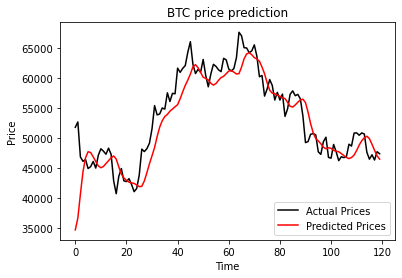

In [ ]:
def test_and_plot(coin_data, model):
    test_start = dt.datetime(2021,9,5) # + dt.timedelta(days=-prediction_days)
    test_end = dt.datetime(2022,1,1)
    
    test_data = pdr.DataReader(f'BTC-USD', 'yahoo', test_start, test_end)
    actual_prices = test_data['Close'].values
    
    total_dataset = pd.concat((coin_data['Close'], test_data['Close']), axis=0)
    
    model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.fit_transform(model_inputs)
    
    x_test = []
    
    for x in range(prediction_days, len(model_inputs)):
        x_test.append(model_inputs[x-prediction_days:x, 0])    
        
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    prediction_prices = model.predict(x_test)
    prediction_prices = scaler.inverse_transform(prediction_prices)     # Turn the values back into USD
    
    actual_price_changes = []
    predicted_price_changes = []
    for i in range(1, len(prediction_prices)):
        if actual_prices[i] >= actual_prices[i-1]:
            actual_price_changes.append('+')
        if actual_prices[i] < actual_prices[i-1]:
            actual_price_changes.append('-')
        if prediction_prices[i] >= prediction_prices[i-1]:
            predicted_price_changes.append('+')
        if prediction_prices[i] < prediction_prices[i-1]:
            predicted_price_changes.append('-')

    num_correct = 0
    for i in range(len(actual_price_changes)):
        if actual_price_changes[i] == predicted_price_changes[i]:
            num_correct += 1
    
    print(num_correct/len(actual_price_changes))
    
    
    pypl.plot(actual_prices, color='black', label='Actual Prices')
    pypl.plot(prediction_prices, color='red', label='Predicted Prices')
    pypl.title(f'BTC price prediction')
    pypl.xlabel('Time')
    pypl.ylabel('Price')
    pypl.legend(loc='lower right')
    pypl.show()

test_and_plot(coin_data[0], trained_model)

## Proper Implementation: SVM With Sentiment Analysis
---
Yeah the last one wasn't good.

In [42]:
# TODO: Need to setup Bitcoin tweets dataset to have label that indicates whether the price went up or down on that day.

    

KeyboardInterrupt: 

In [133]:
# btc_tweets['Compound'] = compound
# btc_tweets['Positive'] = pos
# btc_tweets['Negative'] = neg
# btc_tweets['Neutral'] = neu

# These are all the columns we actually want to keep for the purposes of training & using the model.
model_cols = ['Label','Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Compound', 'Positive', 'Negative', 'Neutral']

btc_prices['Date'] = pd.to_datetime(btc_prices['Date'])
#btc_prices['Date'] = btc_prices['Date'].dt.date
btc_tweets['date'] = pd.to_datetime(btc_tweets['date'])
#btc_tweets['date'] = btc_tweets['date'].dt.date

#Create function to get Sentiment Scores
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

#Get sentiment scores for each day
compound, pos, neg, neu = [], [], [], []
SIA = 0

for i in range(0, len(btc_tweets['text'])):
    SIA = getSIA(btc_tweets['text'][i])
    compound.append(SIA['compound'])                    # Score representing sum(lexicon ratings)
    pos.append(SIA['pos'])
    neg.append(SIA['neg'])
    neu.append(SIA['neu'])

btc_tweets['Compound'] = compound
btc_tweets['Positive'] = pos
btc_tweets['Negative'] = neg
btc_tweets['Neutral'] = neu

In [231]:
print(btc_tweets.loc[btc_tweets['date'] == '[\'YieldFarming\', \'Airdrop\', \'Binance\', \'Bitcoin\', \'pancakeswap\', \'BNB\', \'cryptocurrency\', \'DeFi\', \'BTC\', \'BinanceSmartChain\', \'BSC\', \'pufferswap\', \'DeFi\', \'bsc\', \'bnb\', \'bitcoin\', \'cryto\', \'Airdrop\', \'Airdrop\']'])
#btc_tweets.drop([64943], axis=0, inplace=True)
#btc_tweets.drop([137068], axis=0, inplace=True)
#btc_tweets.drop([180575], axis=0, inplace=True)

btc_tweets['date'] = pd.to_datetime(btc_tweets['date'])
btc_tweets['date'] = btc_tweets['date'].dt.date

btc_tweets = btc_tweets.sort_values(by='date', ascending=True)
dataset_dates = btc_tweets['date'].unique()
num_days = 0
for date in dataset_dates:
    print(date)
    num_days += 1

print(num_days)

split_date = datetime.date(2021,2,10)

# train = btc_tweets.loc[btc_tweets['date'] == split_date]
# test = btc_tweets.loc[btc_tweets['date'] >= split_date]


#print(train)

Empty DataFrame
Columns: [date, text, hashtags]
Index: []
2021-02-05
2021-02-06
2021-02-07
2021-02-08
2021-02-09
2021-02-10
2021-02-13
2021-02-14
2021-02-15
2021-02-18
2021-02-19
2021-02-22
2021-02-28
2021-03-11
2021-03-12
2021-04-05
2021-04-06
2021-04-07
2021-04-08
2021-04-09
2021-04-10
2021-04-11
2021-04-12
2021-04-17
2021-04-18
2021-04-19
2021-04-20
2021-04-21
2021-04-22
2021-04-23
2021-04-24
2021-05-25
2021-05-26
2021-05-27
2021-05-28
2021-05-29
2021-06-20
2021-06-21
2021-06-22
2021-06-23
2021-07-04
2021-07-05
NaT
43


# Newsapi example function call
---
* This will be used in the case that I decide to try to integrate news posts for sentiment analysis.

In [255]:
url = 'https://newsapi.org/v2/everything?'
parameters = {
    'q': 'bitcoin',
    'from': '2022-03-12',
    'to': '2022-04-11',
    'sortBy': 'popularity',
    'apiKey': 'f2162fa3a1ed4fa29bb14cb6a737be55'
}

response = requests.get(url, parameters)
headlines = pd.DataFrame(response.json())

headlines.head(3)


,status,totalResults,articles
0,ok,11728,"{'source': {'id': 'engadget', 'name': 'Engadge..."
1,ok,11728,"{'source': {'id': 'engadget', 'name': 'Engadge..."
2,ok,11728,"{'source': {'id': 'wired', 'name': 'Wired'}, '..."
